In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats

In [2]:
# Change data paths to your own
metadata = pd.read_csv("~/Desktop/processed_metadata.txt", sep="\t")
cluster_labels = pd.read_csv("~/Desktop/sample_clusters.tsv", sep="\t")

# Choose which method to use for clustering if you df has multiple clustering method labels
cluster_labels = cluster_labels.loc[:, ["sample_id", "cluster"]]

In [3]:
# reomve metastatic samples
filtered_cluster_labels = cluster_labels[cluster_labels["sample_id"].apply(lambda x: not x.split('-')[3].startswith("06"))]

# Extract patient IDs
filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]
filtered_cluster_labels = filtered_cluster_labels.rename(columns={"kmeans_cluster_label": "cluster"})
df = pd.merge(filtered_cluster_labels, metadata, on='patient_id')
df = df.drop(columns=["sample_id"])

/var/folders/_k/b8vsv8097ss3sxnsdwkx1y_80000gn/T/ipykernel_16385/1543921108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]


   test_statistic        p  -log2(p)
0       10.942573  0.01204  6.375962


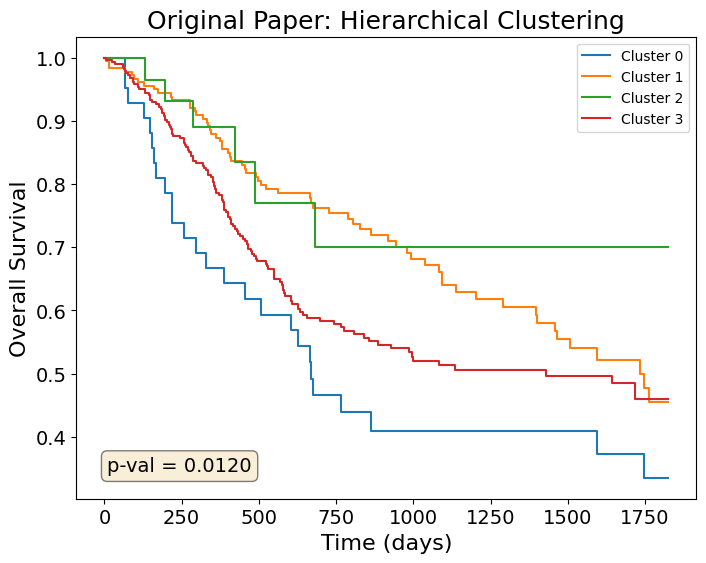

<lifelines.CoxPHFitter: fitted with 543 total observations, 295 right-censored observations>
             duration col = 'OS_time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 543
number of events observed = 248
   partial log-likelihood = -1361.78
         time fit was run = 2025-04-19 01:07:36 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1 -0.62      0.54      0.22           -1.05           -0.20                0.35                0.82
cluster_2 -0.87      0.42      0.42           -1.70           -0.04                0.18                0.96
cluster_3 -0.32      0.73      0.20           -0.71            0.07                0.49                1.08

           cmp to     z      p  -log2(p)
covariate                               
cluster_1    0.00 -2.88 <0.005      7.98
cluster_2    0.00 -2.06   0.04      4.67
cluster_3    0.00 -1.59   0.11      3.15
---
Concordance = 0.57
Partial AIC = 2729.56
log-likelihood ratio test = 10.82 on 3 df
-log2(p) of ll-ratio test = 6.30

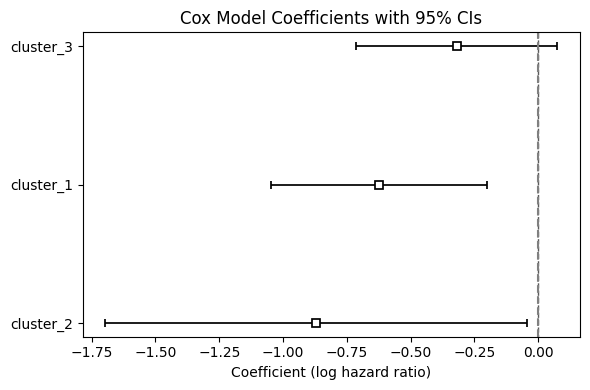

In [7]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization for OS
# -------------------------------------------------
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# define five-year cutoff in days
cutoff_days = 5 * 365
timeline = np.linspace(0, cutoff_days, 500)

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df.groupby('cluster'):
    kmf.fit(cluster_df['OS_time'], timeline=timeline, event_observed=cluster_df['OS'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df['OS_time'], df['cluster'], event_observed=df['OS'])

print(logrank_results.summary)

plt.title("Original Paper: Hierarchical Clustering", fontsize=18)
plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("Overall Survival", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=10, frameon=True)

ax = plt.gca()
ax.text(0.05, 0.05, f"p-val = {logrank_results.p_value:.4f}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
df['cluster'] = df['cluster'].astype(str)
df_encoded = pd.get_dummies(df[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df[['OS_time', 'OS']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, duration_col='OS_time', event_col='OS')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values

plt.figure(figsize=(6, 4))
cph.plot()
plt.title("Cox Model Coefficients with 95% CIs")
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Coefficient (log hazard ratio)")
plt.tight_layout()
plt.show()

   test_statistic         p  -log2(p)
0       12.721663  0.005279  7.565554


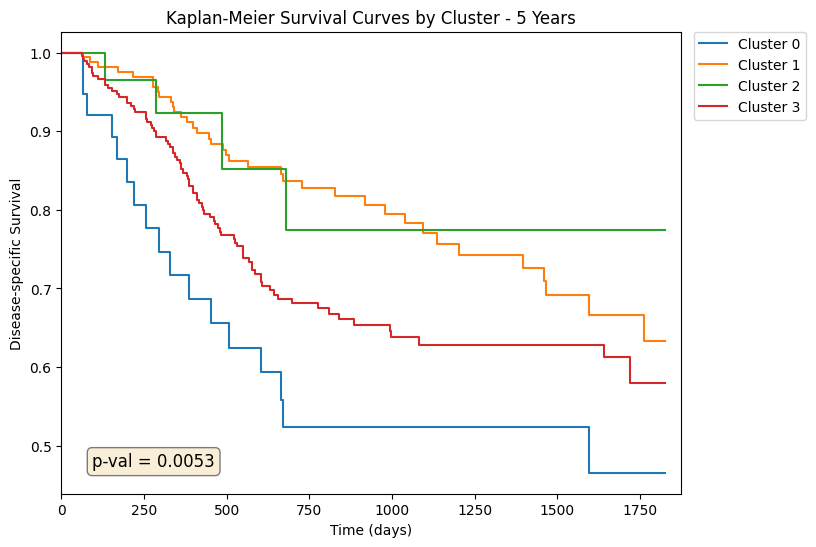

<lifelines.CoxPHFitter: fitted with 514 total observations, 365 right-censored observations>
             duration col = 'DSS_time'
                event col = 'DSS'
      baseline estimation = breslow
   number of observations = 514
number of events observed = 149
   partial log-likelihood = -832.92
         time fit was run = 2025-04-19 00:24:49 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1 -0.90      0.41      0.28           -1.45           -0.34                0.24                0.71
cluster_2 -1.08      0.34      0.55           -2.16            0.01                0.12                1.01
cluster_3 -0.44      0.64      0.26           -0.94            0.06                0.39                1.06

           cmp to     z      p  -log2(p)
covariate                               
cluster_1    0.00 -3.19 <0.005      9.44
cluster_2    0.00 -1.95   0.05      4.29
cluster_3    0.00 -1.74   0.08      3.60
---
Concordance = 0.59
Partial AIC = 1671.85
log-likelihood ratio test = 12.27 on 3 df
-log2(p) of ll-ratio test = 7.26

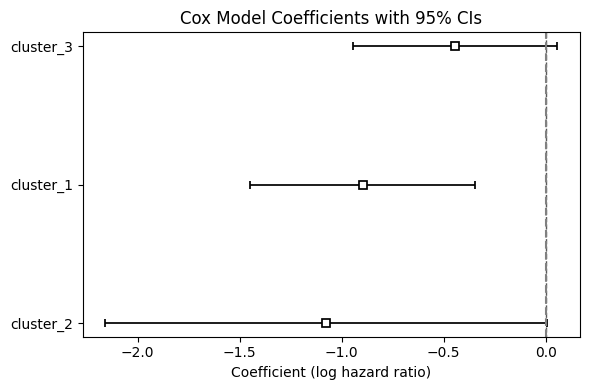

In [5]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization for DSS
# -------------------------------------------------
df_clean = df.dropna(subset=['DSS'])

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df_clean.groupby('cluster'):
    kmf.fit(cluster_df['DSS_time'], timeline=timeline, event_observed=cluster_df['DSS'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df_clean['DSS_time'], df_clean['cluster'], event_observed=df_clean['DSS'])
print(logrank_results.summary)

plt.title("Kaplan-Meier Survival Curves by Cluster - 5 Years")
plt.xlim(0, cutoff_days+50)
plt.xlabel("Time (days)")
plt.ylabel("Disease-specific Survival")
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)

ax = plt.gca()
ax.text(0.05, 0.05, f"p-val = {logrank_results.p_value:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()


# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
#df_clean['cluster'] = df_clean['cluster'].astype(str)
df_encoded = pd.get_dummies(df_clean[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df_clean[['DSS_time', 'DSS']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, duration_col='DSS_time', event_col='DSS')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values

plt.figure(figsize=(6, 4))
cph.plot()
plt.title("Cox Model Coefficients with 95% CIs")
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Coefficient (log hazard ratio)")
plt.tight_layout()
plt.show()


   test_statistic         p  -log2(p)
0        6.685862  0.082614  3.597473


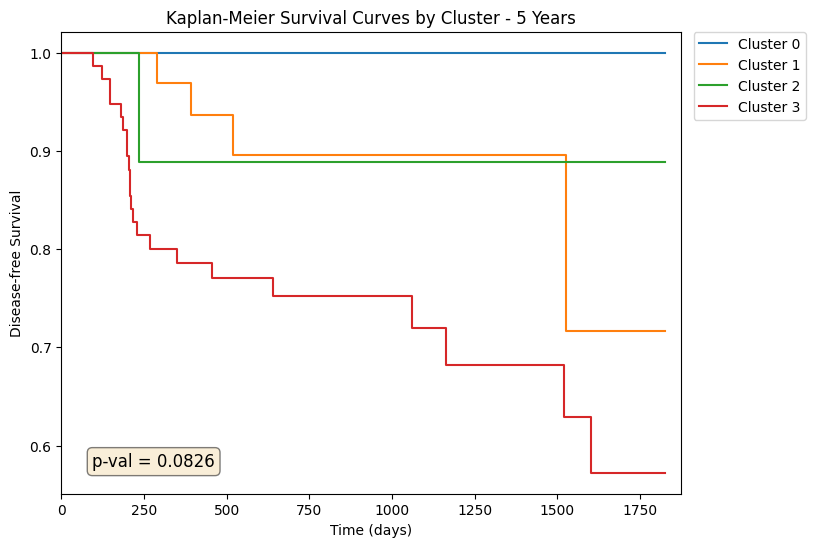

/Users/clairez/miniforge3/envs/py_env/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.713. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 128 total observations, 100 right-censored observations>
             duration col = 'DFI_time'
                event col = 'DFI'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 28
   partial log-likelihood = -116.33
         time fit was run = 2025-04-19 00:25:00 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1 16.22  1.11e+07   2994.93        -5853.74         5886.18                0.00                 inf
cluster_2 16.27  1.16e+07   2994.93        -5853.69         5886.22                0.00                 inf
cluster_3 17.17  2.85e+07   2994.93        -5852.79         5887.12                0.00                 inf

           cmp to    z    p  -log2(p)
covariate                            
cluster_1    0.00 0.01 1.00      0.01
cluster_2    0.00 0.01 1.00      0.01
cluster_3    0.00 0.01 1.00      0.01
---
Concordance = 0.64
Partial AIC = 238.65
log-likelihood ratio test = 9.08 on 3 df
-log2(p) of ll-ratio test = 5.15

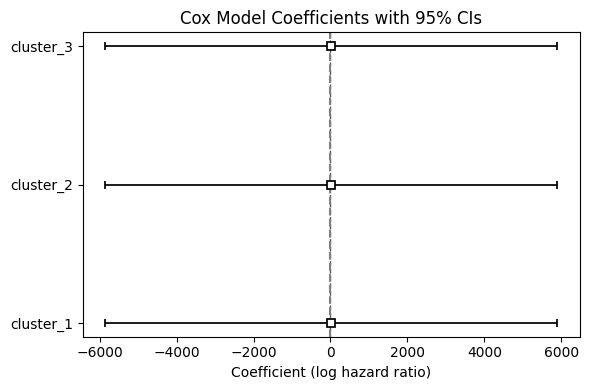

In [6]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization for DFI
# -------------------------------------------------
df_clean = df.dropna(subset=['DFI'])

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df_clean.groupby('cluster'):
    kmf.fit(cluster_df['DFI_time'], timeline=timeline, event_observed=cluster_df['DFI'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df_clean['DFI_time'], df_clean['cluster'], event_observed=df_clean['DFI'])
print(logrank_results.summary)

plt.title("Kaplan-Meier Survival Curves by Cluster - 5 Years")
plt.xlim(0, cutoff_days+50)
plt.xlabel("Time (days)")
plt.ylabel("Disease-free Survival")
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)

ax = plt.gca()
ax.text(0.05, 0.05, f"p-val = {logrank_results.p_value:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
#df_clean['cluster'] = df_clean['cluster'].astype(str)
df_encoded = pd.get_dummies(df_clean[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df_clean[['DFI_time', 'DFI']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, duration_col='DFI_time', event_col='DFI')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values

plt.figure(figsize=(6, 4))
cph.plot()
plt.title("Cox Model Coefficients with 95% CIs")
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Coefficient (log hazard ratio)")
plt.tight_layout()
plt.show()

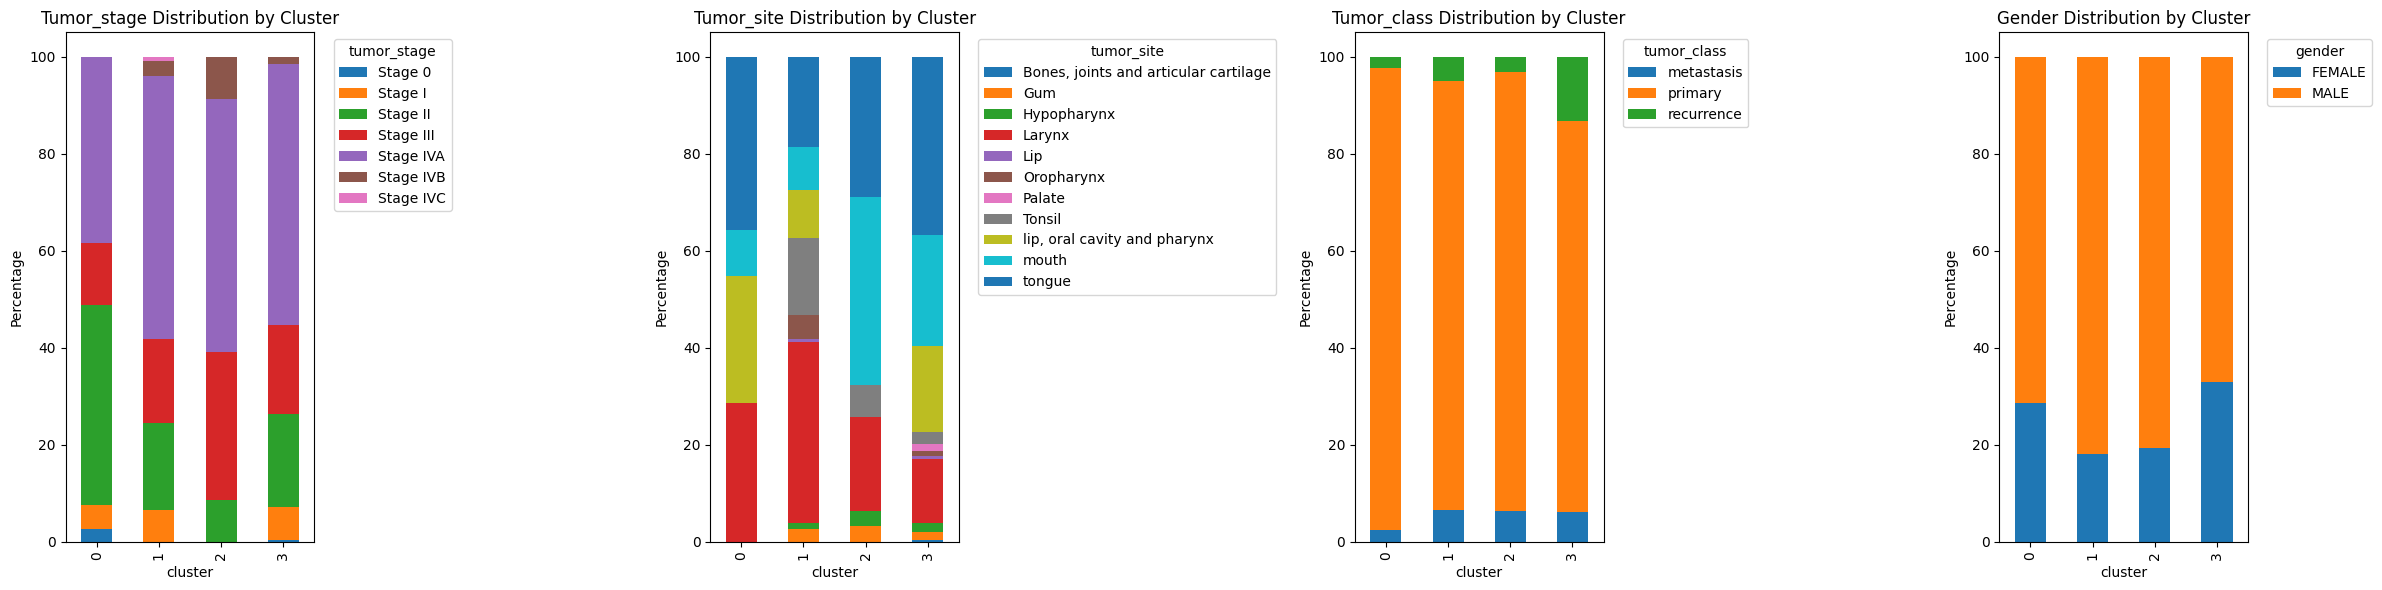

In [7]:
# ============================================================
# Creating Stacked Bar Plots for Each Categorical Variable
# ============================================================
# We will produce one stacked bar plot per variable.
# In each plot the x-axis corresponds to the groups (here: clusters)
# and the bars show the relative percentages of each category for the variable.

df.loc[
  df['tumor_site']=="Bones, joints and articular cartilage of other and unspecified sites",
  'tumor_site'
] = "Bones, joints and articular cartilage"

df.loc[
  df['tumor_site']=="Other and ill-defined sites in lip, oral cavity and pharynx",
  'tumor_site'
] = "lip, oral cavity and pharynx"

variables = ['tumor_stage', 'tumor_site', 'tumor_class', "gender"]

# Create one subplot per variable
fig, axes = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6))

# Iterate over the variables and plot each as a stacked bar chart
for ax, var in zip(axes, variables):
    # Create a contingency table of cluster vs the current variable.
    # The option normalize='index' computes the proportions within each cluster,
    # and multiplying by 100 converts those to percentages.
    ct = pd.crosstab(df['cluster'], df[var], normalize='index') * 100
    
    # Plot the stacked bar chart.
    ct.plot(kind='bar', stacked=True, ax=ax)
    
    # Set labels and title.
    ax.set_ylabel('Percentage')
    ax.set_title(f'{var.capitalize()} Distribution by Cluster')
    
    # Place the legend outside for better readability.
    ax.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout so the subplots don’t overlap.
plt.tight_layout()
plt.show()

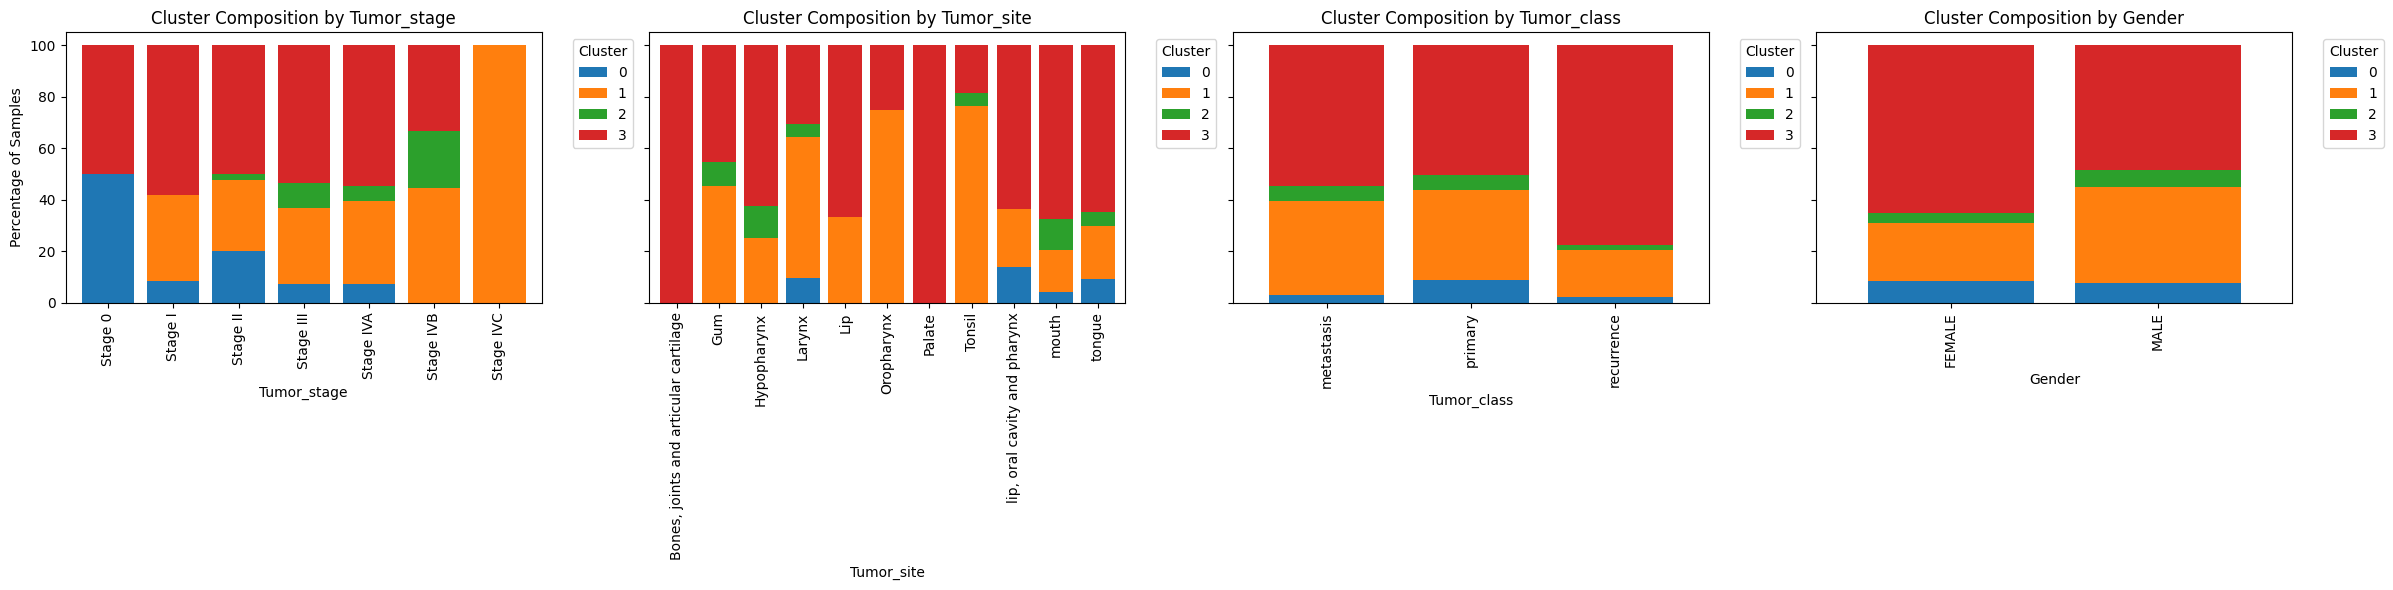

In [8]:
# ============================================================
# Creating Stacked Bar Plots for Each cluster
# ============================================================
# We will produce one stacked bar plot per cluster.
# In each plot the x-axis corresponds to the variables
# and the bars show the relative percentages of each cluster for the variable.

variables = ['tumor_stage', 'tumor_site', 'tumor_class', 'gender']

# One subplot per variable
fig, axes = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6), sharey=True)

for ax, var in zip(axes, variables):
    # contingency table: index=category, columns=cluster
    # normalize='index' → percentages within each category
    ct = pd.crosstab(df[var], df['cluster'], normalize='index') * 100

    # plot stacked bar: x=category, stacks=clusters
    ct.plot(kind='bar', stacked=True, ax=ax, width=0.8)

    ax.set_ylabel('Percentage of Samples' if ax is axes[0] else '')
    ax.set_xlabel(var.capitalize())
    ax.set_title(f'Cluster Composition by {var.capitalize()}')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

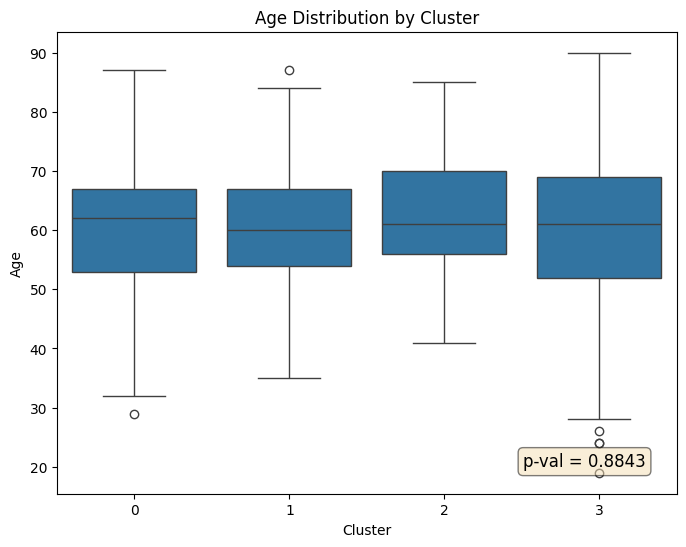

In [9]:
# ============================================================
# Create Boxplot: Age distribution by Cluster
# ============================================================
order = sorted(df['cluster'].unique())

groups = [df[df['cluster'] == cluster]['age'] for cluster in df['cluster'].unique()]
anova_result = stats.f_oneway(*groups)
p_val = anova_result.pvalue

plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='age', data=df, order=order)
plt.title('Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')

ax = plt.gca()
ax.text(0.95, 0.05, f"p-val = {p_val:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()